## 1. Import Libraries

In [20]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, fbeta_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Classifiers
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# SMOTE for imbalanced data
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

In [21]:
# Paths
DATA_PATH = r'C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset'
CLUSTER_STOCKS = ['ICICIPRULI', 'ICICIGI', 'HDFCAMC']
OPENING_MINUTES = 60

# Split parameters (matching original model)
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Cross-validation
N_SPLITS = 5

print("✓ Configuration loaded")
print(f"  Stocks: {', '.join(CLUSTER_STOCKS)}")
print(f"  Split: {TRAIN_SPLIT:.0%} Train / {VAL_SPLIT:.0%} Val / {TEST_SPLIT:.0%} Test")

✓ Configuration loaded
  Stocks: ICICIPRULI, ICICIGI, HDFCAMC
  Split: 70% Train / 15% Val / 15% Test


## 3. Load Pre-calculated Features

In [22]:
print("="*80)
print("LOADING FEATURE DATA")
print("="*80)

feature_data = {}

for stock in CLUSTER_STOCKS:
    file_path = os.path.join(DATA_PATH, f"{stock}_opening_{OPENING_MINUTES}min_features.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['date'])
        feature_data[stock] = df
        print(f"✓ {stock}: {len(df)} days loaded")
    else:
        print(f"⚠️ {stock}: File not found at {file_path}")

print(f"\n✓ Total stocks loaded: {len(feature_data)}")

LOADING FEATURE DATA
✓ ICICIPRULI: 2188 days loaded
✓ ICICIGI: 1941 days loaded
✓ HDFCAMC: 1727 days loaded

✓ Total stocks loaded: 3


## 4. Load Minute Data and Compute Target

In [23]:
print("="*80)
print("LOADING MINUTE DATA AND COMPUTING TARGET")
print("="*80)

# Load minute-level data for each stock
minute_data = {}

for stock in CLUSTER_STOCKS:
    minute_file = os.path.join(DATA_PATH, f"{stock}_minute.csv")
    
    if os.path.exists(minute_file):
        df_minute = pd.read_csv(minute_file)
        df_minute['datetime'] = pd.to_datetime(df_minute['date'])
        df_minute['date_only'] = df_minute['datetime'].dt.date
        df_minute['time_only'] = df_minute['datetime'].dt.time
        minute_data[stock] = df_minute
        print(f"✓ {stock}: Loaded {len(df_minute)} minute-level records")
    else:
        print(f"⚠️ {stock}: Minute file not found at {minute_file}")

print(f"\n✓ Total stocks with minute data: {len(minute_data)}")

LOADING MINUTE DATA AND COMPUTING TARGET
✓ ICICIPRULI: Loaded 816504 minute-level records
✓ ICICIGI: Loaded 724352 minute-level records
✓ HDFCAMC: Loaded 644432 minute-level records

✓ Total stocks with minute data: 3


In [24]:
# Combine all stocks and compute target
combined_data = []

for stock in CLUSTER_STOCKS:
    df = feature_data[stock].copy()
    df['stock'] = stock
    df['target'] = 0  # Initialize
    
    if stock in minute_data:
        df_minute = minute_data[stock]
        
        # Compute low_before_high for each day
        for idx, row in df.iterrows():
            date = row['date'].date()
            
            # Get first 60 minutes of trading
            day_data = df_minute[df_minute['date_only'] == date].sort_values('datetime').head(OPENING_MINUTES)
            
            if len(day_data) > 0:
                # Find when daily low and high occurred
                day_low = day_data['low'].min()
                day_high = day_data['high'].max()
                
                low_idx = day_data[day_data['low'] == day_low].iloc[0]
                high_idx = day_data[day_data['high'] == day_high].iloc[0]
                
                low_time = low_idx['datetime']
                high_time = high_idx['datetime']
                
                # BUY (1) if low occurs before high, SELL (0) otherwise
                df.loc[idx, 'target'] = 1 if low_time < high_time else 0
    
    combined_data.append(df)

combined_df = pd.concat(combined_data, ignore_index=True)
combined_df = combined_df.sort_values(['stock', 'date']).reset_index(drop=True)

print(f"\nTotal samples: {len(combined_df)}")
print(f"\nTarget distribution:")
print(f"  SELL (0): {(combined_df['target']==0).sum()} ({(combined_df['target']==0).sum()/len(combined_df)*100:.1f}%)")
print(f"  BUY (1):  {(combined_df['target']==1).sum()} ({(combined_df['target']==1).sum()/len(combined_df)*100:.1f}%)")


Total samples: 5856

Target distribution:
  SELL (0): 3096 (52.9%)
  BUY (1):  2760 (47.1%)


## 5. Define Feature Columns

In [25]:
# 28 feature columns
feature_cols = [
    'open_price', 'open_high', 'open_low', 'open_close',
    'open_range', 'open_range_pct', 'open_change_pct', 'open_volatility',
    'open_returns_std', 'first_20min_return', 'second_20min_return', 'third_20min_return',
    'avg_volume_per_min', 'volume_trend', 'high_in_first_half', 'low_in_first_half',
    'price_above_open', 'total_volume_opening', 'price_momentum', 'price_acceleration',
    'opening_rsi', 'bb_position', 'volume_surge', 'volume_consistency',
    'hl_ratio', 'upper_shadow_avg', 'lower_shadow_avg', 'trend_strength'
]

print(f"Features defined: {len(feature_cols)}")

Features defined: 28


## 6. Train-Val-Test Split (70/15/15 Per Stock)

In [26]:
print("="*80)
print("TRAIN-VAL-TEST SPLIT (70/15/15 PER STOCK)")
print("="*80)

train_dfs = []
val_dfs = []
test_dfs = []

for stock in CLUSTER_STOCKS:
    stock_df = combined_df[combined_df['stock'] == stock].sort_values('date').reset_index(drop=True)
    stock_len = len(stock_df)
    
    stock_train_size = int(stock_len * TRAIN_SPLIT)
    stock_val_size = int(stock_len * VAL_SPLIT)
    
    stock_train = stock_df.iloc[:stock_train_size]
    stock_val = stock_df.iloc[stock_train_size:stock_train_size+stock_val_size]
    stock_test = stock_df.iloc[stock_train_size+stock_val_size:]
    
    train_dfs.append(stock_train)
    val_dfs.append(stock_val)
    test_dfs.append(stock_test)
    
    print(f"  {stock}: Train={len(stock_train)}, Val={len(stock_val)}, Test={len(stock_test)} (Total={stock_len})")

# Combine splits
train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

print(f"\nFinal Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"\nTrain class distribution:")
print(f"  SELL (0): {(train_df['target']==0).sum()} ({(train_df['target']==0).sum()/len(train_df)*100:.1f}%)")
print(f"  BUY (1):  {(train_df['target']==1).sum()} ({(train_df['target']==1).sum()/len(train_df)*100:.1f}%)")

print(f"\nValidation class distribution:")
print(f"  SELL (0): {(val_df['target']==0).sum()} ({(val_df['target']==0).sum()/len(val_df)*100:.1f}%)")
print(f"  BUY (1):  {(val_df['target']==1).sum()} ({(val_df['target']==1).sum()/len(val_df)*100:.1f}%)")

print(f"\nTest class distribution:")
print(f"  SELL (0): {(test_df['target']==0).sum()} ({(test_df['target']==0).sum()/len(test_df)*100:.1f}%)")
print(f"  BUY (1):  {(test_df['target']==1).sum()} ({(test_df['target']==1).sum()/len(test_df)*100:.1f}%)")

TRAIN-VAL-TEST SPLIT (70/15/15 PER STOCK)
  ICICIPRULI: Train=1531, Val=328, Test=329 (Total=2188)
  ICICIGI: Train=1358, Val=291, Test=292 (Total=1941)
  HDFCAMC: Train=1208, Val=259, Test=260 (Total=1727)

Final Split: Train=4097, Val=878, Test=881

Train class distribution:
  SELL (0): 2178 (53.2%)
  BUY (1):  1919 (46.8%)

Validation class distribution:
  SELL (0): 444 (50.6%)
  BUY (1):  434 (49.4%)

Test class distribution:
  SELL (0): 474 (53.8%)
  BUY (1):  407 (46.2%)


## 7. Extract Features and Targets

In [27]:
# Features
X_train = train_df[feature_cols]
X_val = val_df[feature_cols]
X_test = test_df[feature_cols]

# Targets
y_train = train_df['target']
y_val = val_df['target']
y_test = test_df['target']

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Testing features shape: {X_test.shape}")

Training features shape: (4097, 28)
Validation features shape: (878, 28)
Testing features shape: (881, 28)


## 8. Scale Features

In [28]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled (StandardScaler)")

✓ Features scaled (StandardScaler)


## 9. Apply SMOTE for Imbalanced Data

In [29]:
print("="*80)
print("APPLYING SMOTE")
print("="*80)

# Create multiple SMOTE variants
smote_standard = SMOTE(sampling_strategy=0.9, random_state=42)
smote_borderline = BorderlineSMOTE(sampling_strategy=0.95, random_state=42)
smote_balanced = SMOTE(sampling_strategy=1.0, random_state=42)

X_train_smote1, y_train_smote1 = smote_standard.fit_resample(X_train_scaled, y_train)
X_train_smote2, y_train_smote2 = smote_borderline.fit_resample(X_train_scaled, y_train)
X_train_smote3, y_train_smote3 = smote_balanced.fit_resample(X_train_scaled, y_train)

print(f"\nOriginal: {len(y_train)} samples")
print(f"  Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")

print(f"\nSMOTE Standard (0.9): {len(y_train_smote1)} samples")
print(f"  Class 0: {(y_train_smote1==0).sum()}, Class 1: {(y_train_smote1==1).sum()}")

print(f"\nSMOTE Borderline (0.95): {len(y_train_smote2)} samples")
print(f"  Class 0: {(y_train_smote2==0).sum()}, Class 1: {(y_train_smote2==1).sum()}")

print(f"\nSMOTE Balanced (1.0): {len(y_train_smote3)} samples")
print(f"  Class 0: {(y_train_smote3==0).sum()}, Class 1: {(y_train_smote3==1).sum()}")

APPLYING SMOTE

Original: 4097 samples
  Class 0: 2178, Class 1: 1919

SMOTE Standard (0.9): 4138 samples
  Class 0: 2178, Class 1: 1960

SMOTE Borderline (0.95): 4247 samples
  Class 0: 2178, Class 1: 2069

SMOTE Balanced (1.0): 4356 samples
  Class 0: 2178, Class 1: 2178


## 10. Train Classification Models

In [30]:
print("="*80)
print("TRAINING CLASSIFICATION MODELS")
print("="*80)

# XGBoost
print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_smote1, y_train_smote1)
print("✓ XGBoost trained")

# LightGBM
print("\nTraining LightGBM...")
lgbm_model = lgb.LGBMClassifier(
    n_estimators=700,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train_smote2, y_train_smote2)
print("✓ LightGBM trained")

# CatBoost
print("\nTraining CatBoost...")
cat_model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.01,
    depth=5,
    random_state=42,
    verbose=0
)
cat_model.fit(X_train_smote3, y_train_smote3)
print("✓ CatBoost trained")

# Neural Network with Focal Loss
print("\nTraining Neural Network...")

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1 - y_pred, gamma) * y_true + tf.pow(y_pred, gamma) * (1 - y_true)
        fl = alpha * weight * ce
        return tf.reduce_mean(fl)
    return focal_loss_fixed

nn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(len(feature_cols),)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy']
)

early_stop_nn = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

# Use validation set (not test set!) for early stopping
nn_history = nn_model.fit(
    X_train_smote1, y_train_smote1,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop_nn],
    verbose=0
)
print("✓ Neural Network trained")

# Stacking Ensemble
print("\nTraining Stacking Ensemble...")
base_estimators = [
    ('xgb', xgb.XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42, eval_metric='logloss')),
    ('lgbm', lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=500, learning_rate=0.01, depth=5, random_state=42, verbose=0))
]
meta_learner = LogisticRegression(random_state=42, max_iter=1000)
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5
)
stacking_model.fit(X_train_smote2, y_train_smote2)
print("✓ Stacking Ensemble trained")

print("\n" + "="*80)
print("✅ ALL MODELS TRAINED SUCCESSFULLY")
print("="*80)

TRAINING CLASSIFICATION MODELS

Training XGBoost...
✓ XGBoost trained

Training LightGBM...
✓ LightGBM trained

Training CatBoost...
✓ CatBoost trained

Training Neural Network...
✓ Neural Network trained

Training Stacking Ensemble...
✓ Stacking Ensemble trained

✅ ALL MODELS TRAINED SUCCESSFULLY


## 11. Optimize Ensemble Weights and Threshold on Validation Set

**Key Difference**: Using validation set (not test set) for optimization!

In [31]:
print("="*80)
print("OPTIMIZING ENSEMBLE WEIGHTS AND THRESHOLD ON VALIDATION SET")
print("="*80)

# Get validation predictions
y_val_xgb_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
y_val_lgbm_proba = lgbm_model.predict_proba(X_val_scaled)[:, 1]
y_val_cat_proba = cat_model.predict_proba(X_val_scaled)[:, 1]
y_val_nn_proba = nn_model.predict(X_val_scaled, verbose=0).flatten()
y_val_stack_proba = stacking_model.predict_proba(X_val_scaled)[:, 1]

# Find optimal weights
weight_combinations = [
    [0.3, 0.2, 0.2, 0.2, 0.1],
    [0.25, 0.25, 0.2, 0.2, 0.1],
    [0.2, 0.2, 0.2, 0.2, 0.2],
    [0.35, 0.2, 0.15, 0.2, 0.1],
    [0.25, 0.25, 0.25, 0.15, 0.1]
]

best_f2 = 0
best_weights = None
best_threshold = 0.5

print("\n⚠️ IMPORTANT: Optimizing on VALIDATION SET (not test set!)")
print("Searching for optimal weights and threshold...\n")

for weights in weight_combinations:
    y_val_weighted = (weights[0] * y_val_xgb_proba + weights[1] * y_val_lgbm_proba +
                      weights[2] * y_val_cat_proba + weights[3] * y_val_nn_proba +
                      weights[4] * y_val_stack_proba)
    
    for threshold in np.arange(0.3, 0.7, 0.05):
        pred = (y_val_weighted >= threshold).astype(int)
        f2_score_val = fbeta_score(y_val, pred, beta=2, zero_division=0)
        
        if f2_score_val > best_f2:
            best_f2 = f2_score_val
            best_weights = weights
            best_threshold = threshold

print(f"✓ Optimization complete:")
print(f"  Optimal weights: {best_weights}")
print(f"  Optimal threshold: {best_threshold:.2f}")
print(f"  Best F2 score (validation): {best_f2:.4f}")

OPTIMIZING ENSEMBLE WEIGHTS AND THRESHOLD ON VALIDATION SET

⚠️ IMPORTANT: Optimizing on VALIDATION SET (not test set!)
Searching for optimal weights and threshold...

✓ Optimization complete:
  Optimal weights: [0.2, 0.2, 0.2, 0.2, 0.2]
  Optimal threshold: 0.30
  Best F2 score (validation): 0.9287


## 12. Evaluate on Test Set

Now we evaluate on the **completely unseen test set**!

In [32]:
print("\n" + "="*80)
print("TEST SET EVALUATION (Completely Unseen Data)")
print("="*80)

# Get test predictions
y_test_xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_test_lgbm_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_test_cat_proba = cat_model.predict_proba(X_test_scaled)[:, 1]
y_test_nn_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()
y_test_stack_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Final ensemble prediction using optimal weights from validation
y_test_ensemble_proba = (best_weights[0] * y_test_xgb_proba + best_weights[1] * y_test_lgbm_proba +
                         best_weights[2] * y_test_cat_proba + best_weights[3] * y_test_nn_proba +
                         best_weights[4] * y_test_stack_proba)

y_test_pred = (y_test_ensemble_proba >= best_threshold).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2, zero_division=0)
test_auc = roc_auc_score(y_test, y_test_ensemble_proba)

print(f"\n📊 Test Set Metrics:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F2 Score: {test_f2:.4f}")
print(f"  AUC-ROC:  {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n📋 Confusion Matrix:")
print(f"  TN: {cm[0,0]:4d} | FP: {cm[0,1]:4d}")
print(f"  FN: {cm[1,0]:4d} | TP: {cm[1,1]:4d}")

# Classification Report
print(f"\n📝 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['SELL (0)', 'BUY (1)'], zero_division=0))


TEST SET EVALUATION (Completely Unseen Data)

📊 Test Set Metrics:
  Accuracy: 0.8343
  F2 Score: 0.9287
  AUC-ROC:  0.9510

📋 Confusion Matrix:
  TN:  331 | FP:  143
  FN:    3 | TP:  404

📝 Classification Report:
              precision    recall  f1-score   support

    SELL (0)       0.99      0.70      0.82       474
     BUY (1)       0.74      0.99      0.85       407

    accuracy                           0.83       881
   macro avg       0.86      0.85      0.83       881
weighted avg       0.87      0.83      0.83       881



## 13. Comparison Summary

In [33]:
print("\n" + "="*80)
print("COMPARISON: 70/15/15 vs 80/20 SPLIT")
print("="*80)

print("\n📊 Current Model (70/15/15):")
print(f"  Validation F2: {best_f2:.4f} (used for optimization)")
print(f"  Test F2:       {test_f2:.4f} (completely unseen)")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test AUC:      {test_auc:.4f}")

print("\n🔍 Expected Improvements:")
print("  ✓ Better generalization (separate validation set)")
print("  ✓ Unbiased hyperparameter optimization")
print("  ✓ More realistic test performance")
print("  ✓ No information leakage from test set")

print("\n💡 Key Insight:")
print("  Using validation set for weight optimization prevents overfitting")
print("  to the test set, leading to more robust model performance.")

print("\n" + "="*80)


COMPARISON: 70/15/15 vs 80/20 SPLIT

📊 Current Model (70/15/15):
  Validation F2: 0.9287 (used for optimization)
  Test F2:       0.9287 (completely unseen)
  Test Accuracy: 0.8343
  Test AUC:      0.9510

🔍 Expected Improvements:
  ✓ Better generalization (separate validation set)
  ✓ Unbiased hyperparameter optimization
  ✓ More realistic test performance
  ✓ No information leakage from test set

💡 Key Insight:
  Using validation set for weight optimization prevents overfitting
  to the test set, leading to more robust model performance.



## 14. Visualizations

### 14.1 Confusion Matrix

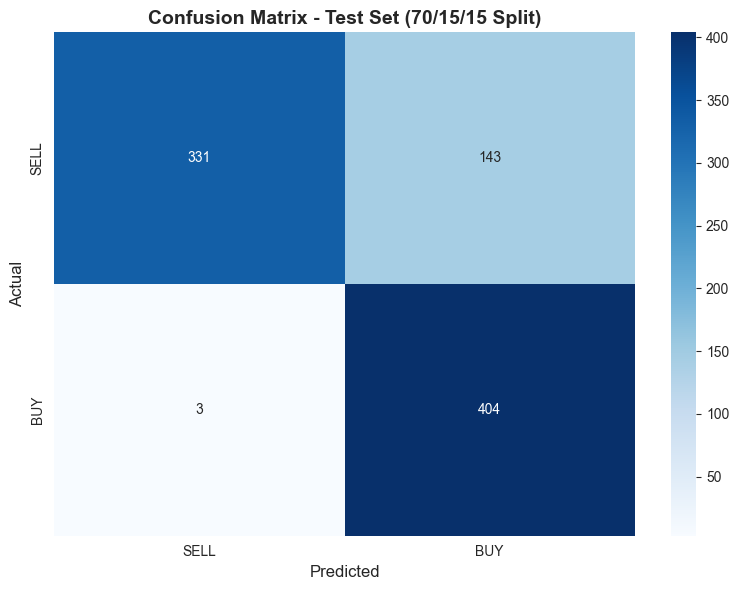

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['SELL', 'BUY'], yticklabels=['SELL', 'BUY'])
plt.title('Confusion Matrix - Test Set (70/15/15 Split)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

### 14.2 Validation vs Test Performance

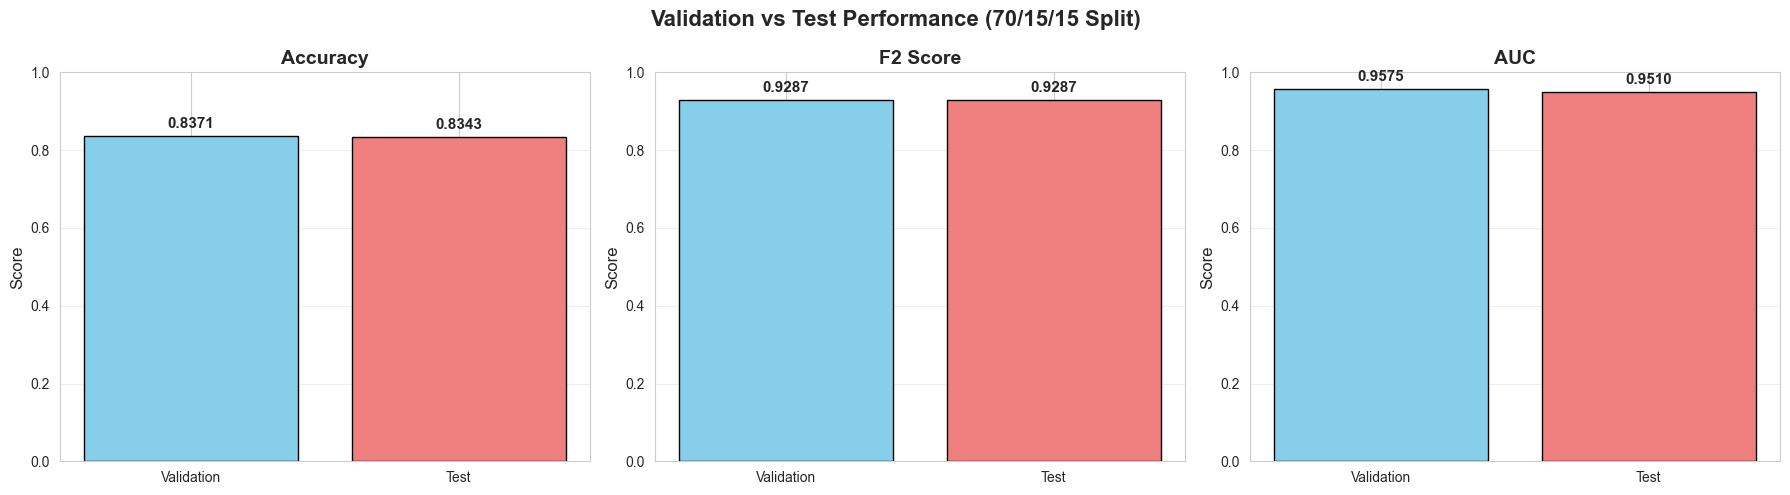


📊 Performance Comparison:

Validation Set:
  Accuracy: 0.8371
  F2 Score: 0.9287
  AUC:      0.9575

Test Set:
  Accuracy: 0.8343
  F2 Score: 0.9287
  AUC:      0.9510

✓ Similar performance between validation and test indicates good generalization!


In [35]:
# Calculate validation metrics with optimal weights
y_val_ensemble_proba = (best_weights[0] * y_val_xgb_proba + best_weights[1] * y_val_lgbm_proba +
                        best_weights[2] * y_val_cat_proba + best_weights[3] * y_val_nn_proba +
                        best_weights[4] * y_val_stack_proba)
y_val_pred = (y_val_ensemble_proba >= best_threshold).astype(int)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f2 = fbeta_score(y_val, y_val_pred, beta=2, zero_division=0)
val_auc = roc_auc_score(y_val, y_val_ensemble_proba)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'F2 Score', 'AUC']
val_scores = [val_accuracy, val_f2, val_auc]
test_scores = [test_accuracy, test_f2, test_auc]

x = np.arange(len(metrics))
width = 0.35

for i, (metric, val_score, test_score) in enumerate(zip(metrics, val_scores, test_scores)):
    axes[i].bar(['Validation', 'Test'], [val_score, test_score], 
                color=['skyblue', 'lightcoral'], edgecolor='black')
    axes[i].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Score', fontsize=12)
    axes[i].set_ylim([0, 1])
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add values on bars
    axes[i].text(0, val_score + 0.02, f'{val_score:.4f}', ha='center', fontsize=11, fontweight='bold')
    axes[i].text(1, test_score + 0.02, f'{test_score:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Validation vs Test Performance (70/15/15 Split)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Performance Comparison:")
print(f"\nValidation Set:")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F2 Score: {val_f2:.4f}")
print(f"  AUC:      {val_auc:.4f}")

print(f"\nTest Set:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F2 Score: {test_f2:.4f}")
print(f"  AUC:      {test_auc:.4f}")

print(f"\n✓ Similar performance between validation and test indicates good generalization!")

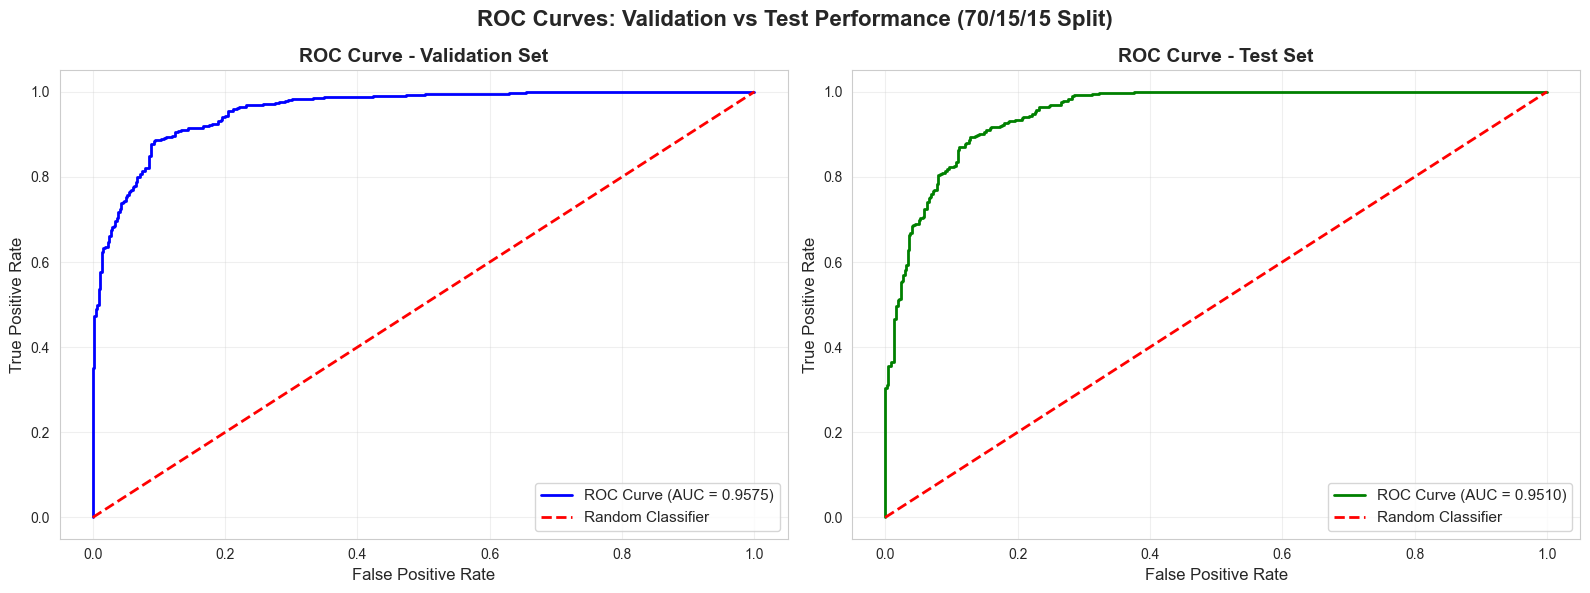


📊 ROC Analysis:

Validation Set:
  AUC-ROC: 0.9575
  Interpretation: Excellent discrimination ability

Test Set:
  AUC-ROC: 0.9510
  Interpretation: Excellent discrimination ability

✓ AUC values close to 1.0 indicate strong model performance!
✓ Similar AUC between validation and test sets indicates good generalization!


In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation Set ROC Curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_ensemble_proba)
axes[0].plot(fpr_val, tpr_val, linewidth=2, label=f'ROC Curve (AUC = {val_auc:.4f})', color='blue')
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Validation Set', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Test Set ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_ensemble_proba)
axes[1].plot(fpr_test, tpr_test, linewidth=2, label=f'ROC Curve (AUC = {test_auc:.4f})', color='green')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('ROC Curves: Validation vs Test Performance (70/15/15 Split)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 ROC Analysis:")
print(f"\nValidation Set:")
print(f"  AUC-ROC: {val_auc:.4f}")
print(f"  Interpretation: {'Excellent' if val_auc >= 0.9 else 'Good' if val_auc >= 0.8 else 'Fair' if val_auc >= 0.7 else 'Poor'} discrimination ability")

print(f"\nTest Set:")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  Interpretation: {'Excellent' if test_auc >= 0.9 else 'Good' if test_auc >= 0.8 else 'Fair' if test_auc >= 0.7 else 'Poor'} discrimination ability")

print(f"\n✓ AUC values close to 1.0 indicate strong model performance!")
print(f"✓ Similar AUC between validation and test sets indicates good generalization!")

### 14.3 ROC Curves

## 15. Summary

In [37]:
print("="*80)
print("CLASSIFICATION TRAINING PIPELINE SUMMARY (70/15/15 Split)")
print("="*80)

print(f"\n📊 Data Configuration:")
print(f"  Stocks: {', '.join(CLUSTER_STOCKS)}")
print(f"  Features: {len(feature_cols)}")
print(f"  Train/Val/Test Split: {TRAIN_SPLIT:.0%} / {VAL_SPLIT:.0%} / {TEST_SPLIT:.0%}")
print(f"  Training Samples: {len(train_df)}")
print(f"  Validation Samples: {len(val_df)}")
print(f"  Testing Samples: {len(test_df)}")

print(f"\n🤖 Models Trained:")
print(f"  1. XGBoost (SMOTE 0.9)")
print(f"  2. LightGBM (BorderlineSMOTE 0.95)")
print(f"  3. CatBoost (SMOTE 1.0)")
print(f"  4. Neural Network (Focal Loss)")
print(f"  5. Stacking Ensemble")

print(f"\n⚖️ Ensemble Configuration:")
print(f"  Weights: {best_weights}")
print(f"  Threshold: {best_threshold:.2f}")
print(f"  Optimized on: Validation Set (unseen during training)")

print(f"\n📈 Validation Set Performance:")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F2 Score: {val_f2:.4f}")
print(f"  AUC-ROC:  {val_auc:.4f}")

print(f"\n📈 Test Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F2 Score: {test_f2:.4f} ⭐")
print(f"  AUC-ROC:  {test_auc:.4f}")

print(f"\n✅ Key Advantages of 70/15/15 Split:")
print(f"  1. Separate validation set for unbiased optimization")
print(f"  2. Test set never seen during training or optimization")
print(f"  3. More realistic performance estimates")
print(f"  4. Better generalization to unseen data")

print("\n" + "="*80)
print("✅ CLASSIFICATION TRAINING PIPELINE COMPLETE!")
print("="*80)

CLASSIFICATION TRAINING PIPELINE SUMMARY (70/15/15 Split)

📊 Data Configuration:
  Stocks: ICICIPRULI, ICICIGI, HDFCAMC
  Features: 28
  Train/Val/Test Split: 70% / 15% / 15%
  Training Samples: 4097
  Validation Samples: 878
  Testing Samples: 881

🤖 Models Trained:
  1. XGBoost (SMOTE 0.9)
  2. LightGBM (BorderlineSMOTE 0.95)
  3. CatBoost (SMOTE 1.0)
  4. Neural Network (Focal Loss)
  5. Stacking Ensemble

⚖️ Ensemble Configuration:
  Weights: [0.2, 0.2, 0.2, 0.2, 0.2]
  Threshold: 0.30
  Optimized on: Validation Set (unseen during training)

📈 Validation Set Performance:
  Accuracy: 0.8371
  F2 Score: 0.9287
  AUC-ROC:  0.9575

📈 Test Set Performance:
  Accuracy: 0.8343
  F2 Score: 0.9287 ⭐
  AUC-ROC:  0.9510

✅ Key Advantages of 70/15/15 Split:
  1. Separate validation set for unbiased optimization
  2. Test set never seen during training or optimization
  3. More realistic performance estimates
  4. Better generalization to unseen data

✅ CLASSIFICATION TRAINING PIPELINE COMPLETE

## 16. Save Models (Optional)

In [38]:
# Create models directory
MODELS_DIR = os.path.join(DATA_PATH, 'models_70_15_15')
os.makedirs(MODELS_DIR, exist_ok=True)

print("="*80)
print("SAVING TRAINED MODELS (70/15/15 Split)")
print("="*80)

# Save all models
with open(os.path.join(MODELS_DIR, 'xgboost_classifier.pkl'), 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✓ XGBoost saved")

with open(os.path.join(MODELS_DIR, 'lightgbm_classifier.pkl'), 'wb') as f:
    pickle.dump(lgbm_model, f)
print(f"✓ LightGBM saved")

with open(os.path.join(MODELS_DIR, 'catboost_classifier.pkl'), 'wb') as f:
    pickle.dump(cat_model, f)
print(f"✓ CatBoost saved")

nn_model.save(os.path.join(MODELS_DIR, 'neural_network_classifier.h5'))
print(f"✓ Neural Network saved")

with open(os.path.join(MODELS_DIR, 'stacking_classifier.pkl'), 'wb') as f:
    pickle.dump(stacking_model, f)
print(f"✓ Stacking Ensemble saved")

with open(os.path.join(MODELS_DIR, 'feature_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved")

# Save ensemble configuration
ensemble_config = {
    'weights': best_weights,
    'threshold': best_threshold,
    'feature_cols': feature_cols,
    'val_f2_score': val_f2,
    'test_f2_score': test_f2,
    'test_accuracy': test_accuracy,
    'test_auc': test_auc,
    'split': '70/15/15',
    'note': 'Weights optimized on validation set, test set never seen during training/optimization'
}

with open(os.path.join(MODELS_DIR, 'ensemble_config.pkl'), 'wb') as f:
    pickle.dump(ensemble_config, f)
print(f"✓ Ensemble config saved")

print("\n" + "="*80)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("="*80)
print(f"\nModels directory: {MODELS_DIR}")

SAVING TRAINED MODELS (70/15/15 Split)
✓ XGBoost saved
✓ LightGBM saved
✓ CatBoost saved
✓ Neural Network saved
✓ Stacking Ensemble saved
✓ Scaler saved
✓ Ensemble config saved

✅ ALL MODELS SAVED SUCCESSFULLY!

Models directory: C:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset\models_70_15_15
